In [ ]:
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Choose a real estate market outside of Utah county. Create a model that depends on time to predict the value of single family homes built 1985 or later. You may include other input to your model like home size, lost, size etc, but you also need to include time as an input. Explain your model in detail.

Let $P_t$ be the median price of the a home in LA county at some month $t$, since July 2016, and $S_t$ be the median home size at that same month $t$.
We can define the median home value at month $t$, defined as $H_t$, to be $H_t (P_t, S_t) = P_t\cdot S_t + \varepsilon_t$.
Here, $\varepsilon_t$ represents the error that the observed measurements for $P_t$ and $S_t$ have that, if incorporated into the measurement, would give us the true median home value $H_t$.

# 2) Obtain freely available, but noisy data regarding the value of single family homes in the market you chose.

In [26]:
df = pd.read_csv('./Datasets/la_county_median_listing_price.csv', index_col=0)
dates = pd.date_range(start='2016-07', end='2025-01', freq='M')
df.index = dates
df = df.rename(columns={'MEDLISPRI6037':'HomeValue_USD'})

In [27]:
price = pd.read_csv('./Datasets/la_county_median_price_sq_ft.csv', index_col=0)
price = price.rename(columns={'MEDLISPRIPERSQUFEE6037': 'med_price_per_sq_ft'})
price.index = dates
df['Price_USD_SQFT'] = price.values.flatten()

size = pd.read_csv('./Datasets/la_county_median_home_size_sq_ft.csv', index_col=0)
size = size.rename(columns={'MEDSQUFEE6037': 'med_size_in_sq_ft'})
size.index = dates
df['Size_SQFT'] = size.values.flatten()

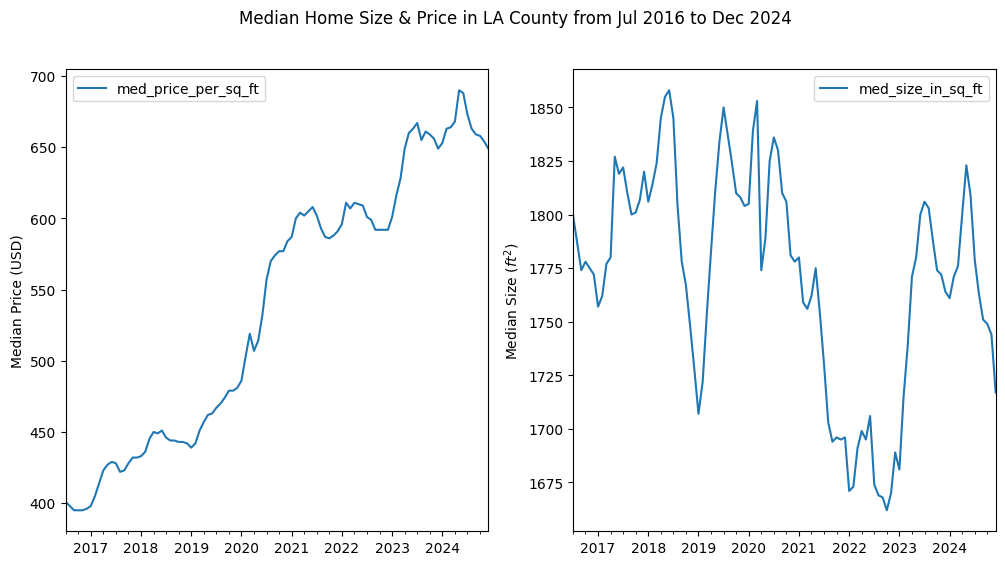

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
price.plot(ax=ax[0])
ax[0].set_ylabel('Median Price (USD)')
size.plot(ax=ax[1])
ax[1].set_ylabel('Median Size ($ft^2$)')
plt.suptitle("Median Home Size & Price in LA County from Jul 2016 to Dec 2024")
plt.show()

In [ ]:
values = price.med_price_per_sq_ft.values.flatten() * size.med_size_in_sq_ft.values.flatten()
df['Predicted_HomeValues_USD'] = values

# 3) Now use Kalman filtering to model the value of homes in your market as time progresses.

In [30]:
# Initialize Kalman filter
kf = KalmanFilter(dim_x=1, dim_z=1)  # 1D state (H_t), 1D observation

# State transition matrix (Random Walk Model)
kf.F = np.array([[1]])  # H_t = H_t-1 + process noise

# Measurement function (Direct observation)
kf.H = np.array([[1]])  # Directly observing home value

# Process noise covariance (uncertainty in state evolution)
kf.Q = np.array([[1]])  # You can tune this

# Measurement noise covariance (sensor noise)
kf.R = np.array([[1]])  # Given that ε_t ~ N(0,1)

# Initial state (first observed home value)
kf.x = np.array([[df.iloc[0]['Predicted_HomeValues_USD']]])  # First value of HomeValue

# Initial state covariance
kf.P = np.array([[100]])  # Large initial uncertainty

# Store results
filtered_values = []

# Apply Kalman filter iteratively
for value in df['HomeValue_USD']:
    kf.predict()
    kf.update(value)
    filtered_values.append(kf.x[0, 0])

# Add filtered values to DataFrame
df['Filtered_HomeValue'] = filtered_values


# 4) Use visuals and brief explanations to demonstrate how your Kalman filtering answer compares to your model without Kalman filtering.

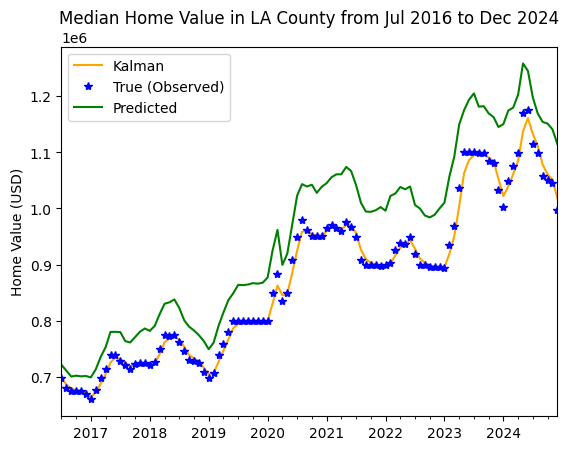

In [40]:
ax = plt.subplot(111)
df['Filtered_HomeValue'].plot(ax=ax, color='orange', label='Kalman', linestyle='-')
df['HomeValue_USD'].plot(ax=ax, color='blue', label='True (Observed)', marker='*', linestyle='')
df['Predicted_HomeValues_USD'].plot(ax=ax, color='green', label='Predicted', linestyle='-')
ax.set_ylabel('Home Value (USD)')
ax.set_title("Median Home Value in LA County from Jul 2016 to Dec 2024")
ax.legend()
plt.show()

My prediction model is not that far off, in shape, from the true observed values of housing data. 
But they are way bigger than true values.
The Kalman filtered values are significantly closer to the true observed values. 